In [1]:
import math
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (cluster_utils,
                                            nn_utils,
                                            portfolio_utils,
                                            random_forest_utils,
                                            time_series_utils,
                                            lstm
                                           )

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [2]:
date_start = '1995-01-01'
date_end = '2010-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker !~ '[\^.~]'
        and character_length(ticker) between 1 and 4
    limit 30
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,open
0,ACY,1999-09-20 05:00:00,7.250000
1,AA,1999-09-20 05:00:00,97.968753
2,ABT,1999-09-20 05:00:00,20.575147
3,ABM,1999-09-20 05:00:00,11.062500
4,AB,1999-09-20 05:00:00,27.000000


### Clean data

In [3]:
def normalize(df, column='open', window_size=1000):
    df['open_min'] = df[column].rolling(window_size).min()
    df['open_max'] = df[column].rolling(window_size).max()
    df[column] = ((df[column] - df['open_min']) / (df['open_max'] - df['open_min']))
    return df

In [4]:
df['target'] = df['open']
df['open_min'], df['open_max'] = 0, 0

df = df.groupby('symbol').apply(normalize)
df = df[df['open'].notnull()]

In [5]:
df = cluster_utils.encode_one_hot(df, ['symbol'])

In [6]:
def sequence_data(df, column='open', length=100):
    dfs = []
    for offset in range(1, length, 1):
        df = df.join(df[column].shift(offset), rsuffix='_' + str(abs(offset)))
    return df

train_test = df.groupby('symbol').apply(sequence_data)


train_test = train_test.dropna()
train_test = train_test.sort_values(by='market_datetime')

print(train_test.shape)
train_test.head(10)

(18150, 123)


,symbol,market_datetime,open,target,open_min,open_max,symbol_A,symbol_AA,symbol_AAP,symbol_AAU,...,open_90,open_91,open_92,open_93,open_94,open_95,open_96,open_97,open_98,open_99
12236,ABT,2004-02-03 06:00:00,0.496197,20.910091,14.354754,27.565912,0,0,0,0,...,0.470208,0.464824,0.464824,0.515075,0.509691,0.511486,0.500000,0.513640,0.489950,0.486001
12238,ABM,2004-02-03 06:00:00,0.817239,17.820000,10.531250,19.450000,0,0,0,0,...,0.511668,0.488464,0.514832,0.530653,0.525379,0.557020,0.547528,0.509558,0.530653,0.514832
12241,ABEV,2004-02-03 06:00:00,0.774504,0.978800,0.432000,1.138000,0,0,0,0,...,0.611898,0.640227,0.669122,0.682720,0.637394,0.651558,0.661756,0.657224,0.684419,0.708215
12242,AB,2004-02-03 06:00:00,0.412857,37.950000,23.500000,58.500000,0,0,0,0,...,0.362857,0.364000,0.358571,0.368571,0.359714,0.353143,0.340571,0.347143,0.327143,0.302286
12243,AA,2004-02-03 06:00:00,0.574561,101.160000,54.000000,136.080000,0,1,0,0,...,0.354532,0.357091,0.362939,0.390351,0.365497,0.364035,0.381944,0.417763,0.374635,0.380117
12249,ABC,2004-02-03 06:00:00,0.620840,13.840000,3.078125,20.412500,0,0,0,0,...,0.617551,0.610050,0.606511,0.598018,0.644020,0.658882,0.672328,0.676999,0.666384,0.670913
12252,ABT,2004-02-04 06:00:00,0.516117,21.173262,14.354754,27.565912,0,0,0,0,...,0.432520,0.470208,0.464824,0.464824,0.515075,0.509691,0.511486,0.500000,0.513640,0.489950
12254,ABM,2004-02-04 06:00:00,0.825088,17.890000,10.531250,19.450000,0,0,0,0,...,0.473698,0.511668,0.488464,0.514832,0.530653,0.525379,0.557020,0.547528,0.509558,0.530653
12255,ABEV,2004-02-04 06:00:00,0.773371,0.978000,0.432000,1.138000,0,0,0,0,...,0.592635,0.611898,0.640227,0.669122,0.682720,0.637394,0.651558,0.661756,0.657224,0.684419
12256,AB,2004-02-04 06:00:00,0.410000,37.850000,23.500000,58.500000,0,0,0,0,...,0.347143,0.362857,0.364000,0.358571,0.368571,0.359714,0.353143,0.340571,0.347143,0.327143


### Train lstm

In [16]:
cols_to_ignore = ['symbol', 'market_datetime', 'open', 'open_min', 'open_max', 'target']

data_size = int(round(len(train_test)/2, -2))

Batch 1, Epoch 0, Loss 7023.603515625
Batch 1, Epoch 50, Loss 1225.50390625
Batch 1, Epoch 100, Loss 1100.116943359375
Batch 1, Epoch 150, Loss 956.692138671875
Batch 1, Epoch 200, Loss 786.8983764648438
Batch 1, Epoch 250, Loss 636.1731567382812
Batch 1, Epoch 300, Loss 539.1580200195312
Batch 1, Epoch 350, Loss 464.7420349121094
Batch 1, Epoch 400, Loss 412.65472412109375
Batch 1, Epoch 450, Loss 375.84552001953125


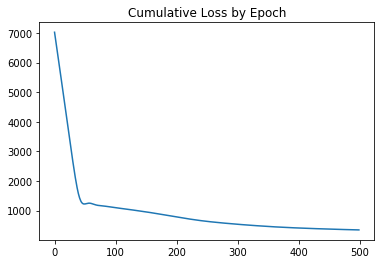

In [9]:
model = TorchLSTM(train_x=train_test.drop(cols_to_ignore, axis=1).head(data_size), 
                           train_y=train_test['open'].head(data_size), 
                           test_x=train_test.drop(cols_to_ignore, axis=1).tail(91), 
                           test_y=train_test['open'].tail(91),
                           n_layers=1,
                           n_epochs=500,
                           hidden_shape=100,
                           dropout=0,
                           learning_rate=.0001,
                           device='cuda:0',
                           seed=6
                          )

model.fit()
model.reset_network()

In [15]:
model.predict()[0][:10]

tensor([[ 0.0076],
        [-0.0028],
        [ 0.0291],
        [ 0.0048],
        [ 0.0356],
        [ 0.0416],
        [ 0.0296],
        [ 0.0300],
        [ 0.0086],
        [ 0.0189]], device='cuda:0', grad_fn=<SliceBackward>)

In [11]:
x = torch.tensor(train_test.drop(cols_to_ignore, axis=1).head(data_size).values
                ).to('cuda:0').float().detach().requires_grad_(True).view((10, 910, 117))

y = torch.tensor(train_test['open'].head(data_size).values).to('cuda:0').view((10, 910, 1))

class MyModel(nn.Module):
    def __init__(self, 
                 n_layers=1,
                 bias=True,
                 dropout=0,
                 batch_size=910,
                 n_training_batches=1,
                 n_epochs=100,
                 learning_rate=.0001,
                 device='cuda',
                 seed=3,
                 deterministic=True,
                 benchmark=False
                ):
        super(MyModel, self).__init__()
        
        torch.manual_seed(3)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  
        np.random.seed(0)

        # Network params
        self.device = 'cuda:0'
        self.n_layers = 1
        self.input_shape = 117
        self.hidden_shape = 1000
        self.output_shape = 1
        self.batch_size = 91
        self.n_training_batches = 1

        self.train_input = (
            int(9100/self.batch_size/self.n_training_batches),
            self.batch_size, 
            self.input_shape
            )
        
        self.lstm = nn.LSTM(input_size=self.input_shape, 
                            hidden_size=self.hidden_shape,
                            num_layers=self.n_layers,
                            bias=bias,
                            dropout=0).to(self.device)
        self.linear2 = nn.Linear(self.input_shape, self.hidden_shape).to(self.device)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.hidden_shape, self.output_shape).to(self.device)
        
#         hidden = torch.zeros(
#             self.n_layers, 
#             self.batch_size, 
#             self.hidden_shape).to(self.device)
#         cell = torch.zeros(
#             self.n_layers, 
#             self.batch_size,
#             self.hidden_shape).to(self.device)

#         self.hidden = hidden, cell
        
    def forward(self, x):
        x, (a, b) = self.lstm(x, None)
#         x = self.linear2(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

model0 = MyModel()
criterion = nn.L1Loss(reduction='sum').to('cuda:0')
optimizer = optim.Adam(model0.parameters(), lr=0.2)


# Train for some epochs
for epoch in range(10):
    optimizer.zero_grad()
    output = model0(x)
    loss = criterion(output.view(-1), y.float().view(-1))
    loss.backward()
    optimizer.step()
    print('Epoch {}, loss {}'.format(epoch, loss.item()))